In [136]:
# https://www.w3schools.com/colors/colors_palettes.asp
# https://stackoverflow.com/questions/49429585/how-to-change-the-background-color-of-a-single-cell-in-a-jupyter-notebook-jupy#comment104601184_50824920
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display
my_palette = ['#edc6a3','#f4ce88','#f0e9ee','#cbcfd9','#c9dac7','#d1d3be','#efe1d5','#e6b4a7','#c0b6a2','#cdb090']
my_palette_names = {'getter':'#e6b4a7', 'init':'#efe1d5'} 
@register_cell_magic
def bgc(color, cell=None):
    if str.isdigit(color) and len(color) == 1:
        color = my_palette[int(color)]
    else:
        color = my_palette_names.get(color, color)
    script = ("var cell = this.closest('.code_cell');"
    "var editor = cell.querySelector('.input_area');"
    "editor.style.background='{}';"
    "this.parentNode.removeChild(this)").format(color) 
    display(HTML('<img src onerror="{}">'.format(script)))

██████████████████████████████████████████

In [239]:
#%%bgc #FFB7B2

#Model
import agentpy as ap
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

██████████████████████████████████████████

In [307]:
#%%bgc #FFDAC1

class Bee(ap.Agent):
    """ A forager from the colony """
    
    def setup(self):  
        """ Initialize a new variable at agent creation """
        self.orientation = model.nprandom.uniform(low = 0.0, high = 360.0) 
        # direction the bee is facing in degrees, East (to the right) is 0º
        
        self.state = "inactive" 
        self.Model = ForagingModel #not sure if I did this right
        self.time_searching = 0 # Counter of how many ticks the bee was in the "searching" state
        self.time_foraging = 0 # Counter of how many ticks the bee was in the "foraging" state
        self.time_returning = 0 # Counter of how many ticks the bee was in the "returning" state
        # Possible states:
        #   "inactive": at the hive
        #   "searching": random foraging
        #   "foraging": found a resource
        #   "returning": en route back to the hive

    def setup_pos(self, space):
        """Make continuous environment"""
        self.space = space 
        self.neighbors = space.neighbors 
        self.pos = space.positions[self]
        
    def move_radially(self, agent, move_dist, move_angle):
        """
        Movement defined by a distance and angle
        Angle is relative to the direction the bee is currently pointed in
        """
        global_angle = agent.orientation + move_angle
        current_x = agent.pos[0]
        current_y = agent.pos[1]
        new_x = current_x + move_dist * np.cos(global_angle)
        new_y = current_y + move_dist * np.sin(global_angle)
        pos = [new_x,new_y]
        self.space.move_to(agent, pos) #I think this should do what we want

    def which_resources_found(self, agent):
        self.on_resource = []
        for r in self.model.resources:
            #if in bounding box's range of x values...
            if r.range_x[0] <= self.pos[0] <= r.range_x[1]:
                #if ALSO in bounding box's range of y values...
                if r.range_y[0] <= self.pos[1] <= r.range_y[1]:
                    # if bee within the plant's radius of the center
                    dist_to_resource = np.sqrt(abs((r.pos[0]-self.pos[0])**2 + (r.pos[1]-self.pos[1])**2))
                    if dist_to_resource <= r.radius:
                        self.on_resource += [r.id] #add to list of resources the bee is on
        return self.on_resource
        
    
    def be_inactive(self):
        """ What the inactive bees do that timestep """
        #self.pos = self.space.positions[self]
        
        
        rg = self.model.random  # Random number generator

        if self.p.p_random_forage > rg.random():
            self.time_searching = 0 # Reset time searching counter
            self.state = "searching"

    ################################################
            
    def search(self):
        """ What the searching bees do that timestep """
        #self.pos = self.space.positions[self]
        
        #Randomly choose direction and distance
        move_dist = model.nprandom.uniform(low = 0.0, high = 10.0)
        move_angle = model.nprandom.uniform(low = -45, high = 45)
        self.move_radially(self, move_dist, move_angle)
        
        self.time_searching += 1 # add 1 tick to the time searching
        resources_found = self.which_resources_found(self)
        
        if resources_found != []: #if found resource, foraging
            self.state = "foraging"
        elif self.time_searching >= self.p.give_up_threshold:
            self.state = "returning"
        else: 
            self.state = "searching"

    ################################################
            
    def forage(self):
        """ What the foraging bees do that timestep """
        #self.pos = self.space.positions[self]
        
        
        self.time_foraging += 1
        if self.time_foraging >= 48:
            self.time_returning = 0
            self.state = "returning"
    
    ################################################
    
    def go_home(self):
        """ What the returning bees do that timestep """
        #self.pos = self.space.positions[self]
        
        
        current_x = self.pos[0] #self.positions[agent][0]
        current_y = self.pos[1]

        if sqrt(current_x**2 + current_y**2)<= self.p.dist_per_tick:
            #if within one step of the hive, go there
            self.pos = [0,0]
            self.move_to(agent, pos)
            self.state = "inactive"
        else:
            global_angle = np.degrees(np.arctan(current_y / current_x)) #Find angle to the hive
            move_angle = global_angle - agent.orientation # correct for bees current orientation
            Bee.move_radially(Bee, self, self.p.dist_per_tick, move_angle)

            


██████████████████████████████████████████

In [302]:
#%%bgc #E2F0CB

class Resource(ap.Agent):
    """ A patch of flowering plants, represented by a circle"""
    
    def setup(self):  
        """ Initialize a new variable at agent creation """
        self.radius = self.p.radius
        
    def setup_pos(self, space):
        self.space = space 
        self.neighbors = space.neighbors 
        self.pos = space.positions[self]
        
        self.range_x = (self.pos[0] - self.radius, self.pos[0] + self.radius)
        self.range_y = (self.pos[1] - self.radius, self.pos[1] + self.radius)

██████████████████████████████████████████

In [303]:
#%%bgc #B5EAD7

class Hive(ap.Agent):
    """ A patch of flowering plants, represented by a circle"""
    
    def setup(self):  
        """ Initialize a new variable at agent creation """
        self.coords = (0,0)

██████████████████████████████████████████

In [304]:
#%%bgc #C7CEEA

class ForagingModel(ap.Model):
    """ Agent-based model that simulates a very 
    simplified version of bee foraging behavior """

    def setup(self):
        """ Initialize the agents"""
        
        #Create ground
        self.space = ap.Space(self, shape=[self.p.land_size]*2)
        
        # Create flowering plants
        self.resources = ap.AgentList(self, self.p.n_resources, Resource)
        self.space.add_agents(self.resources, random=True)
        self.resources.setup_pos(self.space)
        
        #Create hive
        self.hive= ap.AgentList(self, 1, Hive)
        self.space.add_agents(self.hive, [(0,0)], random=False)
        
        # Create bees
        self.bees = ap.AgentList(self, self.p.population, Bee)
        self.space.add_agents(self.bees, [[0,0]]*self.p.population , random=False)  #change to all start at (0,0)
        self.bees.setup_pos(self.space)
        
    def update(self):  
        """ Record variables after setup and each step. """
        for s in ["inactive", "searching", "foraging", "returning"]:
            n_agents = len(self.bees.select(self.bees.state == s))
            self[s] = n_agents / self.p.population 
            self.record(s)

    def step(self):   
        """ Define the models' events per simulation step. """
        
        #Organize the bees into agentlists based on their states
        inactive_bees = self.bees.select(self.bees.state == "inactive")
        searching_bees = self.bees.select(self.bees.state == "searching")
        foraging_bees = self.bees.select(self.bees.state == "foraging")
        returning_bees = self.bees.select(self.bees.state == "returning")

        # Have the bees do things based on their states
        inactive_bees.be_inactive()
        searching_bees.search()
        foraging_bees.forage()
        returning_bees.go_home()

    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
        # Record final evaluation measures
        self.report('Max foragers', max(self.log['foraging']))

██████████████████████████████████████████

In [305]:
#%%bgc #dec1ff

def foraging_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['inactive', 'searching', 'foraging', 'returning']]

    sns.set()  # Set seaborn theme for colors & lines
    ax.stackplot(x, y, 
                 labels=['Inactive', 'Searching', 'Foraging', 'Returning'],
                 colors = ['r', 'b', 'g', 'y'])    

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")
    plt.show()

██████████████████████████████████████████

In [306]:
#%%bgc #c9a2ca

parameters = { 
    'population':5000, 
    'steps':200,
    'p_random_forage': 0.25,
    'p_abandon_search': 0.05,
    'p_find_food': 0.025,
    'land_size': 50,
    'n_resources': 100,
    'radius': 1,
    'give_up_threshold': 120, #threshold for time outside before giving up
}

model = ForagingModel(parameters)
results = model.run() 

Completed: 1 steps
In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In search(self)
self.pos =  [1 0]

About to call WRF...
I've made it inside WRF!!
[1 0]

In search(self)
self.pos =  [0 7]

About to call WRF...
I've made it inside WRF!!
[0 7]

In search(self)
self.pos =  [3 7]

About to call WRF...
I've made it inside WRF!!
[3 7]

In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In search(self)
self.pos =  [4 0]

About to call WRF...
I've made it inside WRF!!
[4 0]

In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In search(self)
self.pos =  [3 0]

About to call WRF...
I've made it inside WRF!!
[3 0]

In search(self)
self.pos =  [0 0]

About to call WRF...
I've made it inside WRF!!
[0 0]

In

KeyboardInterrupt: 

██████████████████████████████████████████

NameError: name 'results' is not defined

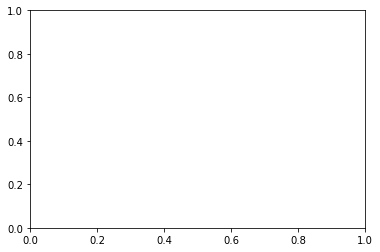

In [100]:
#%%bgc #ecbdd0

fig, ax = plt.subplots()
foraging_stackplot(results.variables.ForagingModel, ax)

██████████████████████████████████████████

In [36]:
#%%bgc #fbd6d7

def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Flocking Model {ndim}D t={m.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
    ax.set_axis_off()

def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

animation_plot(BoidsModel, parameters2D)

██████████████████████████████████████████

In [37]:
#%%bgc #faeade

def animation_plot(model, ax):
    ax.set_title(f"Foraging model \n Time-step: {model.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)

fig, ax = plt.subplots()
model = ForagingModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())